<div style="direction: rtl; text-align: right;">

# گزارش مدل (1D CNN با GRU و SEBlock)

## ۱. خواندن و آماده‌سازی داده‌ها

### پیش‌پردازش
- **خواندن داده‌ها**:
  - فایل‌های CSV با استفاده از `pd.read_csv` خوانده می‌شوند.
  - سیگنال‌ها (`sigs`) و برچسب‌ها (`labels`) جدا می‌شوند.
- **پردازش سیگنال‌ها**:
  - محدود کردن مقادیر خارج از ۹۹.۵ درصدile با `clip_signal`.
  - صاف‌سازی سیگنال‌ها با `smooth_signal` و هسته ۷.
  - کاهش اندازه به طول ثابت ۲۰۴۸ نمونه با `downsample_avg`.
- **ذخیره‌سازی**:
  - داده‌ها به صورت آرایه‌های NumPy ذخیره شده و در پوشه `cache_fast_norm` کش می‌شوند تا از بارگذاری مجدد جلوگیری شود.

### تقسیم داده‌ها
- داده‌ها به سه مجموعه تقسیم می‌شوند:
  - **آموزشی**: ۶۰٪
  - **اعتبارسنجی**: ۲۰٪
  - **تست**: ۲۰٪
- نرمال‌سازی با میانگین و انحراف معیار مجموعه آموزشی انجام می‌شود.

### داده‌افزایی (Augmentation)
- در مجموعه آموزشی:
  - نویز گاوسی با مقیاس ۰.۰۲
  - جابجایی تا حداکثر ۸
  - مقیاس‌دهی بین ۰.۹ تا ۱.۱
  - افزونگی فرکانسی بین ۰.۸۵ تا ۱.۱۵
- احتمال اعمال: ۴۰٪

## ۲. تعریف مدل

مدل یک شبکه کانولوشنی یک‌بعدی (1D CNN) بهبودیافته با GRU و مکانیزم توجه شامل موارد زیر است:

### لایه‌های کانولوشنی
- **conv1_large**:
  - ۳۲ فیلتر، اندازه هسته ۱۵، پدینگ ۷
  - MaxPooling با اندازه ۳
- **conv1_small**:
  - ۳۲ فیلتر، اندازه هسته ۵، پدینگ ۲
  - MaxPooling با اندازه ۳
- **ترکیب**:
  - خروجی `conv1_large` و `conv1_small` با `torch.cat` ترکیب شده و به ۶۴ کانال می‌رسد.
- **conv2**:
  - ۱۲۸ فیلتر، هسته ۷، پدینگ ۳
  - MaxPooling با اندازه ۳
- **conv3**:
  - ۱۹۲ فیلتر، هسته ۵، پدینگ ۲
  - MaxPooling با اندازه ۳
- **conv3_extra**:
  - ۲۵۶ فیلتر، هسته ۵، پدینگ ۲
  - MaxPooling با اندازه ۳
- **conv4**:
  - ۳۲۰ فیلتر، هسته ۳، پدینگ ۱
  - `AdaptiveAvgPool1d` به طول ۱۶

### بلوک Squeeze-and-Excitation (SE)
- پس از `conv2`:
  - کاهش ۱۶ کانالی برای تنظیم پویای کانال‌ها

### Shortcut
- مسیر مستقیم با کانولوشن ۱×۱ و BatchNorm برای ادغام با خروجی اصلی

### لایه GRU
- اندازه ورودی: ۳۲۰
- اندازه پنهان: ۱۶۰
- تعداد لایه‌ها: ۲
- دوجهته
- Dropout: ۰.۲۵

### مکانیزم توجه (Attention)
- اندازه ورودی: ۳۲۰
- تعداد سرهای توجه: ۸
- Dropout: ۰.۱

### لایه‌های Fully Connected
- لایه‌های خطی:
  - ۳۲۰ → ۳۲۰ → ۱۹۲ → ۹۶ → ۱
  - هر لایه با ReLU و Dropout (نسبت‌های ۰.۵، ۰.۴، ۰.۳، ۰.۲)

### جریان داده
- خروجی‌های کانولوشنی با اتصال کوتاه جمع شده، سپس به GRU منتقل شده، با مکانیزم توجه پردازش شده و در نهایت به طبقه‌بندی‌کننده ارسال می‌شوند.

## ۳. یادگیری مدل

### بهینه‌سازی
- بهینه‌ساز: **AdamW**
  - نرخ یادگیری اولیه (گرم‌کردن): `5e-6` برای ۲۰ Epoch اول، سپس `5e-5`
  - وزن‌دهی: `1e-4`
- تابع هزینه: **MSE Loss** با ترکیب:
  - sMAPE با وزن ۰.۰۵
  - L1 Loss با وزن ۰.۰۳
- محدود کردن گرادیان: حداکثر نورم ۰.۷۵

### داده‌افزایی در آموزش
- **Mixup**:
  - آلفا: ۰.۴
  - احتمال: ۴۵٪

### برنامه‌ریزی نرخ یادگیری
- **ReduceLROnPlateau**:
  - فاکتور: ۰.۳
  - صبر: ۱۵
  - حداقل نرخ یادگیری: `1e-8`

### (Early Stopping)
- توقف آموزش پس از ۶۰ Epoch بدون بهبود.

### حفظ بهترین مدل
- ذخیره در: `best_model_cnn_improved.pth` (بر اساس کمترین خطای اعتبارسنجی)

## ۴. تست و نمایش نتایج

### ارزیابی
- معیارها:
  - MSE
  - MAE
  - RMSE
  - R²
  - sMAPE
  - MAE%Max

### نمایش گرافیکی
- **نمودار پراکندگی**: پیش‌بینی‌شده در مقابل واقعی
- **تاریخچه Loss**:
  - نمایش Loss آموزشی و اعتبارسنجی

## ۵. نتایج

### نتایج آموزشی و اعتبارسنجی
- **توقف آموزش**: Epoch ۸۲ (Early Stopping پس از ۶۰ Epoch بدون بهبود)
- **بهترین عملکرد اعتبارسنجی** (Epoch ۲۲):
  - Loss: ۰.۰۰۴۹
  - sMAPE: ۲۶.۰۰٪

### نتایج تست
- **معیارها**:
  - MSE: ۳۷۲۶.۴۷
  - MAE: ۳۴.۹۷
  - RMSE: ۶۱.۰۴
  - R²: ۰.۹۶۰۶
  - sMAPE: ۲۵.۷۲٪
  - MAE%Max: ۴.۰۸٪

</div>

Using device: cuda

===== Epoch 1/300 =====


📉 Train=0.3153 | Val=0.1943 | Val sMAPE=136.39%
✅ (best).

===== Epoch 2/300 =====


📉 Train=0.2872 | Val=0.1810 | Val sMAPE=109.64%
✅ (best).

===== Epoch 3/300 =====


📉 Train=0.2525 | Val=0.1533 | Val sMAPE=80.49%
✅ (best).

===== Epoch 4/300 =====


📉 Train=0.1874 | Val=0.0779 | Val sMAPE=56.93%
✅ (best).

===== Epoch 5/300 =====


📉 Train=0.1049 | Val=0.0225 | Val sMAPE=39.46%
✅ (best).

===== Epoch 6/300 =====


📉 Train=0.0732 | Val=0.0102 | Val sMAPE=32.36%
✅ (best).

===== Epoch 7/300 =====


📉 Train=0.0725 | Val=0.0092 | Val sMAPE=32.69%
✅ (best).

===== Epoch 8/300 =====


📉 Train=0.0628 | Val=0.0094 | Val sMAPE=33.10%

===== Epoch 9/300 =====


📉 Train=0.0653 | Val=0.0075 | Val sMAPE=30.37%
✅ (best).

===== Epoch 10/300 =====


📉 Train=0.0592 | Val=0.0068 | Val sMAPE=29.50%
✅ (best).

===== Epoch 11/300 =====


📉 Train=0.0575 | Val=0.0069 | Val sMAPE=28.20%

===== Epoch 12/300 =====


📉 Train=0.0608 | Val=0.0071 | Val sMAPE=28.67%

===== Epoch 13/300 =====


📉 Train=0.0601 | Val=0.0074 | Val sMAPE=29.41%

===== Epoch 14/300 =====


📉 Train=0.0638 | Val=0.0077 | Val sMAPE=29.96%

===== Epoch 15/300 =====


📉 Train=0.0665 | Val=0.0075 | Val sMAPE=33.70%

===== Epoch 16/300 =====


📉 Train=0.0572 | Val=0.0062 | Val sMAPE=29.11%
✅ (best).

===== Epoch 17/300 =====


📉 Train=0.0581 | Val=0.0056 | Val sMAPE=28.20%
✅ (best).

===== Epoch 18/300 =====


📉 Train=0.0520 | Val=0.0061 | Val sMAPE=26.98%

===== Epoch 19/300 =====


📉 Train=0.0581 | Val=0.0068 | Val sMAPE=29.51%

===== Epoch 20/300 =====


📉 Train=0.0513 | Val=0.0059 | Val sMAPE=26.32%

===== Epoch 21/300 =====


📉 Train=0.0560 | Val=0.0074 | Val sMAPE=30.72%

===== Epoch 22/300 =====


📉 Train=0.0556 | Val=0.0049 | Val sMAPE=26.00%
✅ (best).

===== Epoch 23/300 =====


📉 Train=0.0531 | Val=0.0056 | Val sMAPE=26.33%

===== Epoch 24/300 =====


📉 Train=0.0517 | Val=0.0111 | Val sMAPE=29.53%

===== Epoch 25/300 =====


📉 Train=0.0490 | Val=0.0102 | Val sMAPE=29.17%

===== Epoch 26/300 =====


📉 Train=0.0554 | Val=0.0093 | Val sMAPE=30.45%

===== Epoch 27/300 =====


📉 Train=0.0528 | Val=0.0078 | Val sMAPE=30.20%

===== Epoch 28/300 =====


📉 Train=0.0523 | Val=0.0100 | Val sMAPE=31.25%

===== Epoch 29/300 =====


📉 Train=0.0462 | Val=0.0050 | Val sMAPE=30.43%

===== Epoch 30/300 =====


📉 Train=0.0516 | Val=0.0074 | Val sMAPE=27.42%

===== Epoch 31/300 =====


📉 Train=0.0515 | Val=0.0073 | Val sMAPE=33.79%

===== Epoch 32/300 =====


📉 Train=0.0491 | Val=0.0060 | Val sMAPE=28.98%

===== Epoch 33/300 =====


📉 Train=0.0447 | Val=0.0085 | Val sMAPE=29.78%

===== Epoch 34/300 =====


📉 Train=0.0490 | Val=0.0056 | Val sMAPE=29.12%

===== Epoch 35/300 =====


📉 Train=0.0447 | Val=0.0064 | Val sMAPE=31.27%

===== Epoch 36/300 =====


📉 Train=0.0425 | Val=0.0082 | Val sMAPE=31.47%

===== Epoch 37/300 =====


📉 Train=0.0455 | Val=0.0062 | Val sMAPE=30.12%

===== Epoch 38/300 =====


📉 Train=0.0466 | Val=0.0079 | Val sMAPE=30.31%

===== Epoch 39/300 =====


📉 Train=0.0470 | Val=0.0077 | Val sMAPE=29.62%

===== Epoch 40/300 =====


📉 Train=0.0427 | Val=0.0064 | Val sMAPE=28.15%

===== Epoch 41/300 =====


📉 Train=0.0451 | Val=0.0075 | Val sMAPE=29.10%

===== Epoch 42/300 =====


📉 Train=0.0401 | Val=0.0059 | Val sMAPE=29.44%

===== Epoch 43/300 =====


📉 Train=0.0405 | Val=0.0062 | Val sMAPE=28.88%

===== Epoch 44/300 =====


📉 Train=0.0405 | Val=0.0087 | Val sMAPE=33.57%

===== Epoch 45/300 =====


📉 Train=0.0454 | Val=0.0086 | Val sMAPE=29.22%

===== Epoch 46/300 =====


📉 Train=0.0489 | Val=0.0070 | Val sMAPE=29.07%

===== Epoch 47/300 =====


📉 Train=0.0397 | Val=0.0075 | Val sMAPE=28.59%

===== Epoch 48/300 =====


📉 Train=0.0391 | Val=0.0054 | Val sMAPE=27.41%

===== Epoch 49/300 =====


📉 Train=0.0370 | Val=0.0058 | Val sMAPE=27.99%

===== Epoch 50/300 =====


📉 Train=0.0402 | Val=0.0055 | Val sMAPE=27.18%

===== Epoch 51/300 =====


📉 Train=0.0370 | Val=0.0057 | Val sMAPE=27.74%

===== Epoch 52/300 =====


📉 Train=0.0373 | Val=0.0082 | Val sMAPE=27.67%

===== Epoch 53/300 =====


📉 Train=0.0450 | Val=0.0056 | Val sMAPE=26.95%

===== Epoch 54/300 =====


📉 Train=0.0420 | Val=0.0067 | Val sMAPE=28.28%

===== Epoch 55/300 =====


📉 Train=0.0427 | Val=0.0081 | Val sMAPE=28.92%

===== Epoch 56/300 =====


📉 Train=0.0407 | Val=0.0075 | Val sMAPE=28.00%

===== Epoch 57/300 =====


📉 Train=0.0423 | Val=0.0064 | Val sMAPE=26.93%

===== Epoch 58/300 =====


📉 Train=0.0365 | Val=0.0067 | Val sMAPE=27.91%

===== Epoch 59/300 =====


📉 Train=0.0455 | Val=0.0076 | Val sMAPE=28.60%

===== Epoch 60/300 =====


📉 Train=0.0412 | Val=0.0074 | Val sMAPE=27.24%

===== Epoch 61/300 =====


📉 Train=0.0442 | Val=0.0085 | Val sMAPE=29.22%

===== Epoch 62/300 =====


📉 Train=0.0408 | Val=0.0065 | Val sMAPE=26.78%

===== Epoch 63/300 =====


📉 Train=0.0414 | Val=0.0095 | Val sMAPE=29.72%

===== Epoch 64/300 =====


📉 Train=0.0383 | Val=0.0079 | Val sMAPE=28.25%

===== Epoch 65/300 =====


📉 Train=0.0468 | Val=0.0086 | Val sMAPE=28.72%

===== Epoch 66/300 =====


📉 Train=0.0360 | Val=0.0062 | Val sMAPE=27.44%

===== Epoch 67/300 =====


📉 Train=0.0398 | Val=0.0059 | Val sMAPE=26.52%

===== Epoch 68/300 =====


📉 Train=0.0380 | Val=0.0059 | Val sMAPE=29.91%

===== Epoch 69/300 =====


📉 Train=0.0367 | Val=0.0075 | Val sMAPE=28.44%

===== Epoch 70/300 =====


📉 Train=0.0347 | Val=0.0058 | Val sMAPE=26.54%

===== Epoch 71/300 =====


📉 Train=0.0358 | Val=0.0067 | Val sMAPE=28.08%

===== Epoch 72/300 =====


📉 Train=0.0452 | Val=0.0072 | Val sMAPE=27.78%

===== Epoch 73/300 =====


📉 Train=0.0380 | Val=0.0066 | Val sMAPE=27.33%

===== Epoch 74/300 =====


📉 Train=0.0432 | Val=0.0065 | Val sMAPE=27.76%

===== Epoch 75/300 =====


📉 Train=0.0432 | Val=0.0067 | Val sMAPE=26.39%

===== Epoch 76/300 =====


📉 Train=0.0306 | Val=0.0053 | Val sMAPE=26.48%

===== Epoch 77/300 =====


📉 Train=0.0384 | Val=0.0064 | Val sMAPE=27.14%

===== Epoch 78/300 =====


📉 Train=0.0405 | Val=0.0067 | Val sMAPE=26.81%

===== Epoch 79/300 =====


📉 Train=0.0414 | Val=0.0068 | Val sMAPE=26.82%

===== Epoch 80/300 =====


📉 Train=0.0428 | Val=0.0066 | Val sMAPE=26.31%

===== Epoch 81/300 =====


📉 Train=0.0395 | Val=0.0065 | Val sMAPE=27.95%

===== Epoch 82/300 =====


📉 Train=0.0392 | Val=0.0069 | Val sMAPE=27.67%
⏹️ Early stopping.


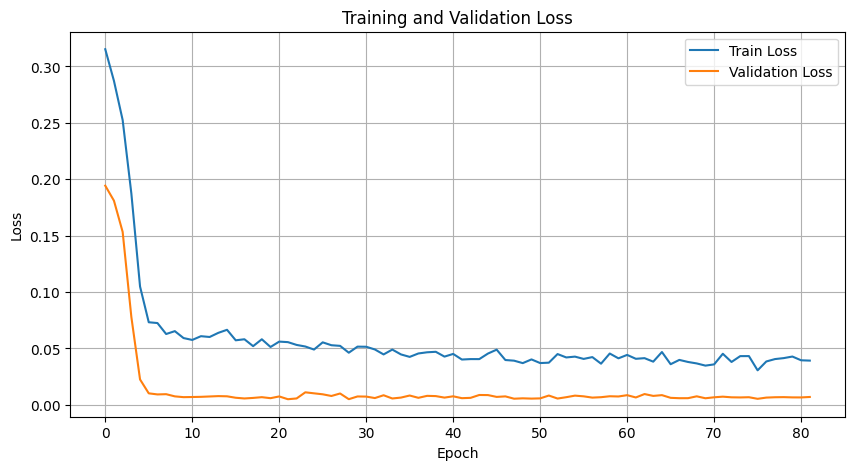

C:\Users\x515a\AppData\Local\Temp\ipykernel_23912\758600130.py:446: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CACHE_DIR / "best_model_cn

✅ Test: MSE=3726.47, MAE=34.97, RMSE=61.04, R2=0.9606, sMAPE=25.72%, MAE%Max=4.08%


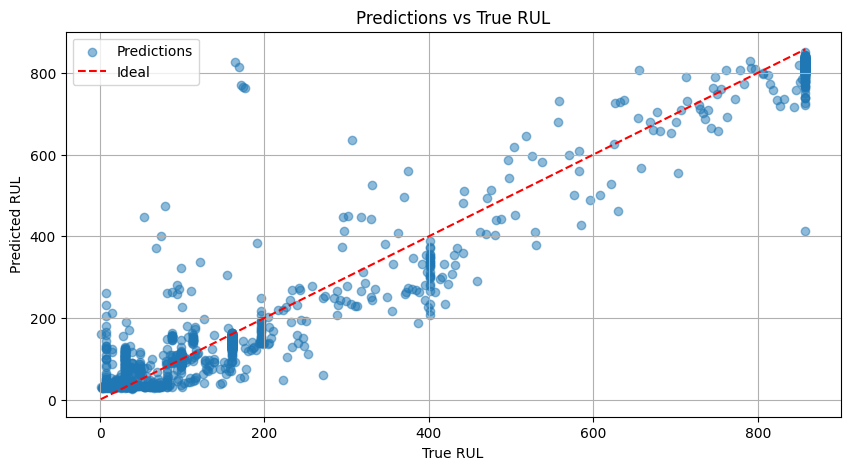

ValueError: bins must be monotonically increasing or decreasing

In [2]:
import os
import math
import random
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import kurtosis

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


BASE_DIR = Path(r"D:\DRIVE\UNI\moviZ\TERM8\ANN-article--AzRiz\OurWorks\Data-description\phase1")
REVERSED_FOLDER = "reversed"
CACHE_DIR = Path("cache_fast_norm")
CACHE_DIR.mkdir(exist_ok=True, parents=True)

TARGET_LEN = 2048
SMOOTH_KERNEL = 7
BATCH_SIZE = 64
EPOCHS = 300
LR = 5e-5
WARMUP_LR = 5e-6
WARMUP_EPOCHS = 20
WEIGHT_DECAY = 1e-4
PATIENCE = 60
VAL_RATIO = 0.2
TEST_RATIO = 0.2
SEED = 42
AUGMENT = True
DEBUG = False

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.set_num_threads(max(1, os.cpu_count() // 2))

def smooth_signal(x, kernel=SMOOTH_KERNEL):
    if kernel is None or kernel <= 1:
        return x.astype(np.float32, copy=False)
    k = np.ones(kernel, dtype=np.float32) / kernel
    return np.convolve(x.astype(np.float32, copy=False), k, mode='same')

def downsample_avg(signal, target_len):
    if len(signal) == target_len:
        return signal.astype(np.float32, copy=False)
    parts = np.array_split(signal, target_len)
    return np.array([p.mean(dtype=np.float32) for p in parts], dtype=np.float32)

def clip_signal(signal, clip_percentile=99.5):
    clip_value = np.percentile(np.abs(signal), clip_percentile)
    return np.clip(signal, -clip_value, clip_value)

def frequency_augmentation(signal, scale_range=(0.85, 1.15)):
    freq = np.fft.fft(signal)
    scale = np.random.uniform(*scale_range)
    freq = freq * scale
    return np.fft.ifft(freq).real.astype(np.float32)

def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def get_all_files(base_dir):
    files = list(base_dir.rglob(f"*/{REVERSED_FOLDER}/*.csv"))
    return sorted([f for f in files if f.is_file()])

def find_degradation_start(signals):
    kurt = np.array([kurtosis(s) for s in signals])
    kurt = smooth_signal(kurt, kernel=5)
    normal_end = min(50, len(kurt) // 5)
    mean_normal = np.mean(kurt[:normal_end])
    std_normal = np.std(kurt[:normal_end])
    threshold = mean_normal + 3 * std_normal
    for i in range(normal_end, len(kurt)):
        if kurt[i] > threshold:
            return i
    return len(kurt) // 2

def preprocess_and_cache(files):
    print("📦 Preprocessing & Caching (once)...")
    X_list, y_list = [], []
    max_rul = 0.0
    for f in tqdm(files):
        df = pd.read_csv(f, header=None, dtype=np.float32)
        sigs = df.iloc[:, :-1].values
        labels = df.iloc[:, -1].values.astype(np.float32)
        if labels.size == 0:
            continue
        deg_start = find_degradation_start(sigs)
        rul_at_start = labels[deg_start]
        adjusted_labels = labels.copy()
        adjusted_labels[:deg_start] = rul_at_start
        max_rul = max(max_rul, float(adjusted_labels.max()))
        for sig, lab in zip(sigs, adjusted_labels):
            sig = clip_signal(sig)
            if SMOOTH_KERNEL > 1:
                sig = smooth_signal(sig, SMOOTH_KERNEL)
            sig_ds = downsample_avg(sig, TARGET_LEN)
            X_list.append(sig_ds)
            y_list.append(lab)
    X = np.asarray(X_list, dtype=np.float32)
    y = np.asarray(y_list, dtype=np.float32)
    np.save(CACHE_DIR / "X_raw.npy", X)
    np.save(CACHE_DIR / "y.npy", y)
    np.save(CACHE_DIR / "max_rul.npy", np.array([max_rul], dtype=np.float32))
    print(f"✅ Cached raw: X={X.shape}, y={y.shape}, max_rul={max_rul:.2f}")

def load_cached_raw():
    X = np.load(CACHE_DIR / "X_raw.npy")
    y = np.load(CACHE_DIR / "y.npy")
    max_rul = float(np.load(CACHE_DIR / "max_rul.npy")[0])
    return X, y, max_rul

def split_indices(n_samples, test_ratio=TEST_RATIO, val_ratio=VAL_RATIO, seed=SEED):
    idx = np.arange(n_samples)
    rng = np.random.RandomState(seed)
    rng.shuffle(idx)
    n_test = int(test_ratio * n_samples)
    n_val = int(val_ratio * (n_samples - n_test))
    return idx[n_test + n_val:], idx[n_test:n_test + n_val], idx[:n_test]

def compute_train_norm_stats(X_train):
    mean = X_train.mean(axis=0, dtype=np.float64).astype(np.float32)
    std = X_train.std(axis=0, dtype=np.float64).astype(np.float32)
    std[std < 1e-6] = 1.0
    return mean, std

class BearingDataset(Dataset):
    def __init__(self, X, y, max_rul, mean, std, train=False, augment=AUGMENT):
        self.X_raw = X
        self.y = (y / max_rul).astype(np.float32)
        self.mean, self.std = mean, std
        self.augment = augment and train
        self.noise_scale = 0.02
        self.shift_max = 8
        self.scale_range = (0.9, 1.1)
        self.freq_scale_range = (0.85, 1.15)

    def __len__(self):
        return len(self.X_raw)

    def __getitem__(self, idx):
        x = self.X_raw[idx].copy()
        if self.augment:
            noise = np.random.normal(0, self.noise_scale * self.std, size=x.shape).astype(np.float32)
            x = x + noise
            shift = np.random.randint(-self.shift_max, self.shift_max)
            x = np.roll(x, shift)
            scale = np.random.uniform(*self.scale_range)
            x = x * scale
            if np.random.random() < 0.4:
                x = frequency_augmentation(x, self.freq_scale_range)
        x = ((x - self.mean) / self.std).astype(np.float32)
        return torch.from_numpy(x).unsqueeze(0), torch.tensor(self.y[idx], dtype=torch.float32)

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

class ImprovedBestModel(nn.Module):
    def __init__(self, input_len=TARGET_LEN):
        super().__init__()
        self.conv1_large = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=15, padding=7),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(32, momentum=0.2),
            nn.MaxPool1d(3)
        )
        self.conv1_small = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(32, momentum=0.2),
            nn.MaxPool1d(3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128, momentum=0.2),
            nn.MaxPool1d(3)
        )
        self.se_block = SEBlock(128)
        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(192, momentum=0.2),
            nn.MaxPool1d(3)
        )
        self.conv3_extra = nn.Sequential(
            nn.Conv1d(192, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256, momentum=0.2),
            nn.MaxPool1d(3)
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(256, 320, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(320, momentum=0.2),
            nn.AdaptiveAvgPool1d(16)
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, input_len)
            out1 = self.conv1_large(dummy)
            out2 = self.conv1_small(dummy)
            out = torch.cat([out1, out2], dim=1)
            out = self.conv2(out)
            out = self.se_block(out)
            out = self.conv3(out)
            out = self.conv3_extra(out)
            out = self.conv4(out)
            output_length = out.size(2)
            output_channels = out.size(1)

        total_downsample = input_len // output_length
        self.shortcut = nn.Sequential(
            nn.Conv1d(1, output_channels, kernel_size=1, stride=total_downsample),
            nn.BatchNorm1d(output_channels, momentum=0.2)
        )

        self.gru = nn.GRU(input_size=320, hidden_size=160, num_layers=2, batch_first=True, bidirectional=True, dropout=0.25)
        self.attn = nn.MultiheadAttention(embed_dim=320, num_heads=8, dropout=0.1, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(320, 320),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(320, 192),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(192, 96),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(96, 1)
        )

    def forward(self, x):
        residual = self.shortcut(x)
        x1 = self.conv1_large(x)
        x2 = self.conv1_small(x)
        x = torch.cat([x1, x2], dim=1)
        x = self.conv2(x)
        x = self.se_block(x)
        x = self.conv3(x)
        x = self.conv3_extra(x)
        x = self.conv4(x)
        if DEBUG:
            print(f"x shape: {x.shape}, residual shape: {residual.shape}")
        x = x + residual
        x = x.permute(0, 2, 1)  # (batch, seq_len=16, feature=320)
        x, hn = self.gru(x)
        hn = hn.view(2, 2, x.size(0), 160)
        last_hn = torch.cat((hn[-1, 0], hn[-1, 1]), dim=1)  # For GRU, hn is (num_layers*dir, batch, hidden)
        x = self.attn(x, x, x)[0]
        x = x.mean(dim=1)
        x = self.classifier(x)
        return x.squeeze(1)

def smape_loss(pred, y):
    return torch.mean(2 * torch.abs(pred - y) / (torch.abs(pred) + torch.abs(y) + 1e-6))

def fit(model, train_loader, val_loader, max_epochs, base_lr, warmup_lr, warmup_epochs, weight_decay, patience):
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=warmup_lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=15, min_lr=1e-8)
    best_val = float('inf')
    best_ep = -1
    history = {"train": [], "val": [], "val_smape": []}

    # Check for CUDA availability
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    print(f"Using device: {device}")

    for epoch in range(1, max_epochs + 1):
        print(f"\n===== Epoch {epoch}/{max_epochs} =====")
        if epoch == warmup_epochs + 1:
            for param_group in optimizer.param_groups:
                param_group['lr'] = base_lr
        model.train()
        train_loss, n = 0, 0
        for X, y in tqdm(train_loader, desc="Train", leave=False):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            if np.random.random() < 0.45:
                X, y_a, y_b, lam = mixup_data(X, y)
                pred = model(X)
                mse_loss = lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
                smape = lam * smape_loss(pred, y_a) + (1 - lam) * smape_loss(pred, y_b)
            else:
                pred = model(X)
                mse_loss = criterion(pred, y)
                smape = smape_loss(pred, y)
            l1_loss = torch.mean(torch.abs(pred - y)) * 0.03
            loss = mse_loss + 0.05 * smape + l1_loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.75)
            optimizer.step()
            train_loss += loss.item() * X.size(0)
            n += X.size(0)
        train_loss /= n

        model.eval()
        val_loss, val_smape, n = 0, 0, 0
        with torch.no_grad():
            for X, y in tqdm(val_loader, desc="Val", leave=False):
                X, y = X.to(device), y.to(device)
                pred = model(X)
                loss = criterion(pred, y)
                val_loss += loss.item() * X.size(0)
                val_smape += (2 * torch.abs(pred - y) / (torch.abs(pred) + torch.abs(y) + 1e-6)).mean().item() * X.size(0)
                n += X.size(0)
        val_loss /= n
        val_smape = 100 * val_smape / n

        history["train"].append(train_loss)
        history["val"].append(val_loss)
        history["val_smape"].append(val_smape)
        print(f"📉 Train={train_loss:.4f} | Val={val_loss:.4f} | Val sMAPE={val_smape:.2f}%")
        scheduler.step(val_loss)

        if val_loss < best_val - 1e-4:
            best_val = val_loss
            best_ep = epoch
            torch.save(model.state_dict(), CACHE_DIR / "best_model_cnn_improved.pth")
            print("✅ (best).")
        elif epoch - best_ep >= patience:
            print("⏹️ Early stopping.")
            break
    return history

def evaluate_test(model, test_loader, max_rul):
    # Check for CUDA availability
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for X, y in tqdm(test_loader, desc="Test", leave=False):
            X, y = X.to(device), y.to(device)
            pred = model(X).cpu().numpy() * max_rul
            true = y.cpu().numpy() * max_rul
            preds.extend(pred.tolist())
            trues.extend(true.tolist())
    preds, trues = np.array(preds), np.array(trues)
    mse = mean_squared_error(trues, preds)
    mae = mean_absolute_error(trues, preds)
    rmse = math.sqrt(mse)
    r2 = r2_score(trues, preds)
    smape = 100 * np.mean(2 * np.abs(preds - trues) / (np.abs(preds) + np.abs(trues) + 1e-6))
    mae_pct = 100 * mae / (trues.max() if trues.max() > 0 else 1.0)
    print(f"✅ Test: MSE={mse:.2f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.4f}, sMAPE={smape:.2f}%, MAE%Max={mae_pct:.2f}%")
    
    plt.figure(figsize=(10, 5))
    plt.scatter(trues, preds, alpha=0.5, label="Predictions")
    plt.plot([trues.min(), trues.max()], [trues.min(), trues.max()], 'r--', label="Ideal")
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title("Predictions vs True RUL")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Ensure bins are monotonically increasing
    base_bins = [0, 500, 1000, 1500, 2000]
    if max_rul > 2000:
        bins = base_bins + [max_rul + 1]
        bin_labels = ['0-500', '500-1000', '1000-1500', '1500-2000', f'2000+']
    else:
        bins = base_bins[:4] + [max_rul + 1]
        bin_labels = ['0-500', '500-1000', '1000-1500', f'1500+']
    
    true_bins = np.digitize(trues, bins, right=False)
    pred_bins = np.digitize(preds, bins, right=False)
    cm = confusion_matrix(true_bins, pred_bins, labels=range(len(bin_labels)))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=bin_labels, yticklabels=bin_labels)
    plt.xlabel('Predicted RUL Category')
    plt.ylabel('True RUL Category')
    plt.title('Confusion Matrix for RUL Prediction')
    plt.show()
    
    return preds, trues

def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history["train"], label="Train Loss")
    plt.plot(history["val"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

def run():
    if not (CACHE_DIR / "X_raw.npy").exists():
        files = get_all_files(BASE_DIR)
        if not files:
            raise RuntimeError("reversed not found")
        preprocess_and_cache(files)
    X_raw, y, max_rul = load_cached_raw()
    train_idx, val_idx, test_idx = split_indices(len(X_raw))
    mean, std = compute_train_norm_stats(X_raw[train_idx])

    train_ds = BearingDataset(X_raw[train_idx], y[train_idx], max_rul, mean, std, train=True)
    val_ds = BearingDataset(X_raw[val_idx], y[val_idx], max_rul, mean, std)
    test_ds = BearingDataset(X_raw[test_idx], y[test_idx], max_rul, mean, std)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

    model = ImprovedBestModel(TARGET_LEN)
    history = fit(model, train_loader, val_loader, EPOCHS, LR, WARMUP_LR, WARMUP_EPOCHS, WEIGHT_DECAY, PATIENCE)
    plot_history(history)
    model.load_state_dict(torch.load(CACHE_DIR / "best_model_cnn_improved.pth"))
    evaluate_test(model, test_loader, max_rul)

if __name__ == "__main__":
    run()